<a href="https://colab.research.google.com/github/jmythms/ThermalComfort/blob/master/Test_for_imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is meant to be run on Google Colab. 

Click on the "open in Colab" button if you are in Github. 

Then upload the DBII.csv. 

Then press (ctrl/cmd + F9) to run all cells. 

In [186]:
# activate R magic, Allows using R in the Notebook, put %%R to make that 
# cell an R script

%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Logistic regression with the TC DB II

## Perfer Cooler Classifier

Any comments you find in this section also apply to the prefer warmer classifier code following this. 

In [0]:
#Python Imports

#It's not great to import everything all the time, as it can make your program slower,
#But I don't care much since this system has enough memory, enough CPU power and 
# I can call all the functions I want without having to import them again. 

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from IPython.core.interactiveshell import InteractiveShell
from sklearn.utils.multiclass import unique_labels
import matplotlib.ticker as ticker
import os, os.path
import seaborn as sns
import numpy as np
# from uncertain_panda import pandas as pd #helps calculate uncertainity in pandas calculations
import pandas_profiling as pp
from google.colab import files
import datetime

In [0]:
# Allows plotting matplotlib plots in the same script

%matplotlib inline  
pd.set_option('display.max_colwidth', -1)

In [189]:
# Loads the (untouched) TC DB II csv to an R dataframe
%%R

TCDBII = read.csv("DBII.csv", fileEncoding="latin1")

str(TCDBII)  #Gives a small summary of your dataframe

'data.frame':	30286 obs. of  66 variables:
 $ Publication..Citation.              : Factor w/ 29 levels "","Andamon, Mary Myla. \"Thermal comfort and building energy consumption in the Philippine context.\" PLEA 2006-Th"| __truncated__,..: 20 20 20 20 20 20 20 20 20 20 ...
 $ Data.contributor                    : Factor w/ 28 levels "Alison Kwok",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ Year                                : int  2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 ...
 $ Season                              : Factor w/ 5 levels "","Autumn","Spring",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Climate                             : Factor w/ 15 levels "Cold semi-arid",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ City                                : Factor w/ 45 levels "Athens","Auburn",..: 42 42 42 42 42 42 42 42 42 42 ...
 $ Country                             : Factor w/ 18 levels "Australia","Brazil",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ Building.type                       : Factor w/ 4 levels "Classroom"

In [190]:
# Remove the rows that have the output variables set to NA or empty cells


%%R

TCDBII = TCDBII[!is.na(TCDBII$Thermal.sensation.acceptability), ]
TCDBII = TCDBII[!is.na(TCDBII$Thermal.preference), ]

TCDBII = TCDBII[!(TCDBII$Thermal.sensation.acceptability==""),]
TCDBII = TCDBII[!(TCDBII$Thermal.preference==""),]

write.csv(TCDBII, file = "Checkpoint1.csv") # write the output to a .csv so that Python can read it from here.

str(TCDBII)

'data.frame':	17997 obs. of  66 variables:
 $ Publication..Citation.              : Factor w/ 29 levels "","Andamon, Mary Myla. \"Thermal comfort and building energy consumption in the Philippine context.\" PLEA 2006-Th"| __truncated__,..: 20 20 20 20 20 20 20 20 20 20 ...
 $ Data.contributor                    : Factor w/ 28 levels "Alison Kwok",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ Year                                : int  2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 ...
 $ Season                              : Factor w/ 5 levels "","Autumn","Spring",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Climate                             : Factor w/ 15 levels "Cold semi-arid",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ City                                : Factor w/ 45 levels "Athens","Auburn",..: 42 42 42 42 42 42 42 42 42 42 ...
 $ Country                             : Factor w/ 18 levels "Australia","Brazil",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ Building.type                       : Factor w/ 4 levels "Classroom"

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/naniar_0.4.2.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2971573 bytes (2.8 MB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/d

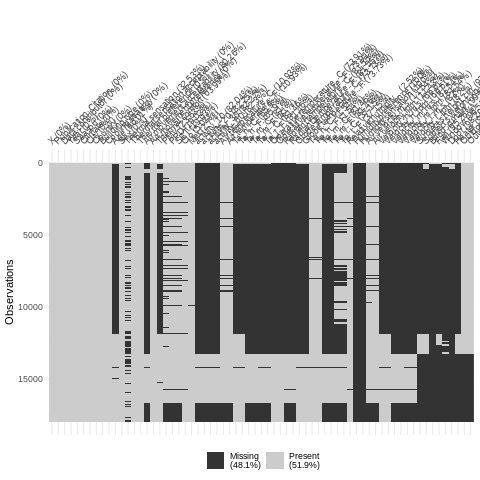

In [191]:
# R code here calculates the percentage of missing data in each variable:
%%R

db_perc_missing_data = read.csv("Checkpoint1.csv", fileEncoding="latin1")

install.packages("naniar")
install.packages("ggplot2")

library(naniar)
library(ggplot2)

g <- vis_miss(db_perc_missing_data,
         warn_large_data = FALSE)       # Creates the plot for missing data

aspect_ratio <- 2.5
height <- 7
print(g)  # this plots g and the next command saves it
ggsave('missing_no.png', height = 7 , width = 7 * aspect_ratio) # Look for missing_no.png on the left pane

In [192]:
# Define a python function that tests if a variable is numeric, returns a bool value

def testNonNumeric(xNew):
  # xNew = float(xNew)
  xNew= str(xNew) # Convert to string
  try:
        float(xNew) # Check if float
        return True
  except ValueError:
        return False

testNonNumeric("ab") # This is a test: you can try to put different stuff in the brackets


False

In [0]:
# Reverted to python beccause I am very comfortable in Python and because Colab lets me do it
# This cell was written as a test for the imputation

TCDBII = pd.read_csv('Checkpoint1.csv') # This reads the 'Checkpoint1.csv' to a pandas dataframe called TCDBII
# TCDBII = pd.read_csv('Checkpoint2.csv')  #Uncomment to read the csv that was generated from CHPC, the imputed data

TCDBII = TCDBII[['Thermal.sensation.acceptability',       # This filters the database to only have relavant columns
                 'Thermal.preference',
                 "Clo",
                  "Met" ,
                  "Air.temperature...C.",
                  "Radiant.temperature...C.",
                  "Relative.humidity...."               ,
                  "Air.velocity..m.s."                ,
                  "Climate"                             ,
                  "Country" ,
                  "Building.type"                       ,
                  "Age"                                 ,
                  "Sex"                                 ,
                  "Ta_h...C."  ,
                  "Ta_m...C."                           ,
                  "Ta_l...C."                           ,
                  "Globe.temperature...C."              ,
                  "Tg_h...C."               ,
                  "Tg_m...C."                           ,
                  "Tg_l...C."                           ,
                  "Velocity_h..m.s."                    ,
                  "Velocity_m..m.s."                    ,
                  "Velocity_l..m.s."                    ,
                  "Subject.s.height..cm."               ,
                  "Subject.s.weight..kg."               ,
                  "Blind..curtain."                     ,
                  "Fan"                                 ,
                  "Window"                              ,
                  "Door"                                ,
                  "Heater"                              ,
                  "Outdoor.monthly.air.temperature...C."]]

TCDBII = TCDBII[[                                       # Here we filter the dataframe to only have the variables that are uncommented
                 'Thermal.sensation.acceptability',     # This is where we select the variables that go into the imputation test. It was not present in the original study
                 'Thermal.preference',
                 "Clo",
                 "Air.temperature...C.",
                 "Air.velocity..m.s."                ,
                 "Tg_h...C."               ,

                #  "Clo" ,
                #  "Radiant.temperature...C.",
                #  "Tg_h...C.",
                #  "Ta_h...C.",
                #  "Sex"
                 ]]

# TCDBII.applymap(testNonNumeric)
TCDBII = TCDBII.dropna(axis=0, how= 'any')              # Drop any rows that have na

TCDBII.to_csv("Checkpoint2.csv")                   # Write the dataframe to a csv so it can become input for subsequent cells. Also is a checkpoint.

# Problem here is the TCDBII dataframe didn't update the R dataframe, so the next cell fixes that


In [194]:
TCDBII

,Thermal.sensation.acceptability,Thermal.preference,Clo,Air.temperature...C.,Air.velocity..m.s.,Tg_h...C.
0,1,warmer,0.25,24.2,0.06,24.0
1,1,no change,0.25,24.2,0.06,24.0
2,1,no change,0.27,24.2,0.06,24.0
3,0,no change,0.23,24.2,0.06,24.0
4,1,no change,0.34,24.2,0.06,24.0
...,...,...,...,...,...,...
16632,1,cooler,0.41,23.6,0.15,24.0
16633,0,cooler,0.45,23.0,0.17,23.3
16634,1,no change,0.24,23.4,0.07,23.8
16635,0,cooler,0.29,24.2,0.11,24.6


In [195]:
# This rewrites the R dataframe called TCDBII, reading it from the csv written in the previous cell

%%R

TCDBII = read.csv("Checkpoint2.csv")


str (TCDBII)

'data.frame':	14884 obs. of  7 variables:
 $ X                              : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Thermal.sensation.acceptability: int  1 1 1 0 1 1 1 1 0 1 ...
 $ Thermal.preference             : Factor w/ 3 levels "cooler","no change",..: 3 2 2 2 2 2 2 2 1 2 ...
 $ Clo                            : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C.           : num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.             : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.                      : num  24 24 24 24 24 24 24 24 24 24 ...


In [0]:
# error

In [197]:
# R cell
# This cell reads the csv from the last cell 
# Then drops all OUTPUT (That somehow can be used to predict thermal comfort) variables 
# This is necessary because we will One-hot encode the categorical variables in the next cell
# Many of our output variables are categorical variables and we dont want to one hot encode them
# We will deal with these variables separately later and we don't want R/Python/anything_else to mess with this data now. 

%%R
# imputed

imputed = read.csv("Checkpoint2.csv")

drop <- c("TCDBII.Thermal.sensation",                   # A list of all the variables that can represent thermal comfort, as the variables appear in the dataframe when the TC DBII CSV is read using R
          "Thermal.sensation",
          "Heater",
          "Thermal.sensation.acceptability"     ,
          "Thermal.preference"                  ,
          "Air.movement.acceptability"          ,
          "Air.movement.preference"             ,
          "Thermal.comfort"                     ,
          "PMV"                                 ,
          "PPD"                                 ,
          "SET"                                 )

imputed = imputed[,!(names(imputed) %in% drop)]       # Drop all the columns in the list above

str(imputed)


'data.frame':	14884 obs. of  5 variables:
 $ X                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                 : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C.: num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.  : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.           : num  24 24 24 24 24 24 24 24 24 24 ...


In [198]:
# This cell exists to one hot encode the "categorical" or Non numerical variables. 
# This is effectively useless since variables like Gender (which had text like "Male" or "Female") don't exist in the workflow anymore


%%R
# imputed

# imputed = read.csv("Checkpoint2.csv")

# # drop <- c("TCDBII$Thermal.sensation", "Heater","Blind..curtain.")
# drop <- c("TCDBII.Thermal.sensation",
#           "Thermal.sensation",
#           "Heater",
#           "Thermal.sensation.acceptability"     ,
#           "Thermal.preference"                  ,
#           "Air.movement.acceptability"          ,
#           "Air.movement.preference"             ,
#           "Thermal.comfort"                     ,
#           "PMV"                                 ,
#           "PPD"                                 ,
#           "SET"                                 )

# imputed = imputed[,!(names(imputed) %in% drop)]

install.packages("mltools")
library(mltools)
library(data.table)                 # Stuff that R needs to make magic that follows 

imputed = one_hot(as.data.table(imputed, keep.rownames=TRUE), dropCols = TRUE, dropUnusedLevels = FALSE) # This is where the one-hot-encoding happens
names(imputed)<-make.names(names(imputed),unique = TRUE)
impute<-imputed[ , colSums(is.na(imputed)) == 0]            # I put this everywhere because I am scared of NAs
str(imputed)

# We add back our output variables(Thermal comfort predictors) to the imputed dataframe

imputed <- cbind(imputed, Thermal.acceptability = TCDBII$Thermal.sensation.acceptability)
imputed <- cbind(imputed, Thermal.preference =TCDBII$Thermal.preference)

str(imputed)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/mltools_0.3.5.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 32471 bytes (31 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dis

Classes ‘data.table’ and 'data.frame':	14884 obs. of  6 variables:
 $ rn                  : chr  "1" "2" "3" "4" ...
 $ X                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                 : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C.: num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.  : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.           : num  24 24 24 24 24 24 24 24 24 24 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes ‘data.table’ and 'data.frame':	14884 obs. of  8 variables:
 $ rn                   : chr  "1" "2" "3" "4" ...
 $ X                    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                  : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C. : num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.   : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.            : num  24 24 24 

In [0]:
# Write whatever was done before this into a new csv to be used by R/Python/Anything_else that follows

%%R

write.csv(imputed, file = "Checkpoint3.csv")

In [200]:
# This cell processes the TC predictor variables.
# A new variable called cooler/warmer is created to replace both Thermal Preference and Thermal Acceptability)
# 'cooler'/'warmer' is 1 if the occupant wants to be cooler/warmer and 0 if they want no change

# Sadly coming back to Python, because I have done this kind of stuff in Python before, and I am familiar with it. 


classifier = pd.read_csv("Checkpoint3.csv")      # Read csv, as always

classifier['Thermal.preference'] = classifier['Thermal.preference'].apply(lambda row: 1 if row == 'cooler' else 0)    # Convert TP to 0 or 1 depending if it is supposed to be cooler or warmer
# 1 is if  unnacceptable and prefer cooler
classifier['cooler'] = np.where((classifier['Thermal.acceptability'] == 0) & (classifier['Thermal.preference'] == 1), 1, 0) # Created a new variable called 'cooler' which is 1 when TP and TA is 1 and 0 in all other cases
# Thermal acceptability : If 0, unacceptable
classifier = classifier.drop(["Unnamed: 0",'rn', 'X'],axis = 'columns')         # Drop all the artifacts that were created from reading between Pandas and R
classifier = classifier.drop(['Thermal.acceptability', 'Thermal.preference'], axis=1)     # Drop both the TA and TP columns since we don't need them anymore

classifier['cooler'].value_counts()     # Shows the number of 0s and 1s in the cooler column

0    12802
1    2082 
Name: cooler, dtype: int64

In [201]:
## Dropping highly correlated features

# Commented out for the imputation test since I just have 3-4 variables left and I cannot afford to let this code cell take away anymore of my variables. 

## A lot of my variables are highly correlated. Doesn't matter since everyone's life is messed up somewhere.


df = classifier 

# df = df[['Country_Canada', 'Country_UK', 'Fan', 'Outdoor.monthly.air.temperature...C.']]

# Create correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.to_csv("classifierCorrelation.csv", index=False)        # Checkpoint csv

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))     

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]    #This makes a list of variables that are too(greater than 0.9) correlated 

# Drop features 
# df = df.drop(df[to_drop], axis=1)  # This doesn't happen anymore since I don't want to drop any of the 3 variables I have left


print("Highly correlated variables being dropped: ", to_drop)

classifier = df
classifier.to_csv("Checkpoint4.csv", index=False)           # Checkpoint csv

Highly correlated variables being dropped:  ['Tg_h...C.']


In [0]:
forML = pd.read_csv("Checkpoint4.csv")

forML=forML.dropna(axis='columns')            # drop all NAs all the time 

forML.to_csv("Checkpoint4.csv",index=False)

# We are moving back to R from this point. 

In [203]:
# R cell (all cells that have  %%R is an R cell)
# This is where the logistic regression happens


%%R

install.packages("caTools")
library(caTools)

TCLog = read.csv("Checkpoint4.csv") # Read the csv from the last cells

set.seed(1000)                                            # Seed set for reproducibility 
split = sample.split(TCLog$cooler, SplitRatio = 0.8)      # Split to 8:2 ratio
Train = subset(TCLog, split == TRUE)                      # Assign to Train and Test
Test = subset(TCLog, split == FALSE)
TCLogModel = glm(cooler ~ ., data = Train, family = binomial)   # Model created
predictTest = predict(TCLogModel, type = "response", newdata = Test)    # Prediction, predicted values using the Test Data and Model is assigned to predictTest

summary(TCLogModel)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/caTools_1.18.0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 64577 bytes (63 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/di


Call:
glm(formula = cooler ~ ., family = binomial, data = Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9430  -0.5651  -0.4419  -0.3206   2.8927  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -9.96791    0.37411 -26.644  < 2e-16 ***
Clo                  -1.19676    0.13122  -9.120  < 2e-16 ***
Air.temperature...C. -0.09320    0.03113  -2.994  0.00275 ** 
Air.velocity..m.s.   -2.23456    0.41080  -5.440 5.34e-08 ***
Tg_h...C.             0.47209    0.03228  14.627  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 9640.5  on 11907  degrees of freedom
Residual deviance: 8690.0  on 11903  degrees of freedom
AIC: 8700

Number of Fisher Scoring iterations: 5



In [0]:
# R Cell
# Saves the coefficients to "Checkpoint5.csv"

%%R

write.csv(summary(TCLogModel)$coefficients, file = "Checkpoint5.csv")   

In [0]:
# CoolerClassifierSummary = pd.read_csv("Checkpoint5.csv")
# CoolerClassifierSummary

Text(0.5, 1.0, 'Prefer Cooler Classifier')

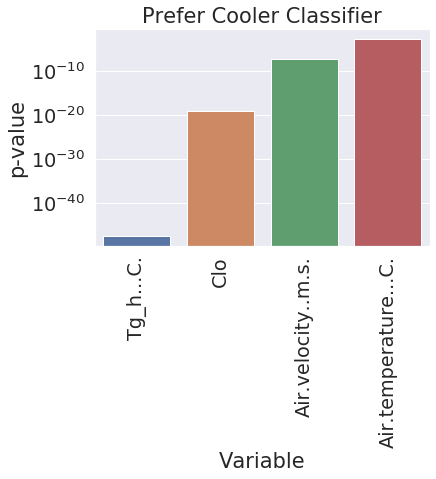

In [206]:
# Python cell for making plots
# Uses seaborn

import pandas as pd
import seaborn as sns

CoolerClassifierSummary = pd.read_csv("Checkpoint5.csv")
CoolerClassifierSummary = CoolerClassifierSummary[CoolerClassifierSummary['Pr(>|z|)'] < 0.1]                # We just need p values less than 0.1
CoolerClassifierSummary = CoolerClassifierSummary[CoolerClassifierSummary["Unnamed: 0"] != '(Intercept)']   # We don't want the intercept in the variable list (intercept of the regression line/curve)
CoolerClassifierSummary = CoolerClassifierSummary.sort_values(by=["Pr(>|z|)"])                              # Sort by order of significance

# CoolerClassifierSummary #Uncomment to take a peek at what is happening

sns.set(font_scale=1.75)    

g = sns.barplot(x="Unnamed: 0", y="Pr(>|z|)", data=CoolerClassifierSummary,                                 # Create plot
                # order='Pr(>|z|)'
                )
g.set_yscale("log")

g.set_xticklabels(g.get_xticklabels(),rotation=90)
# labels = ['T_g high', 'Clo', 'T_mrt', 'T_a low', 'T_a high', 'T_a mid', 'Hot summ med', 'T_g low', 'Velocity low', 'Velocity mid', 'Gender', 'Met']
# g.set(xticklabels=labels)
g.set_xlabel("Variable")
g.set_ylabel("p-value")
g.set_title('Prefer Cooler Classifier')

In [0]:
# This was code for calculating the AUC for just the significant variables, when all the TC DBII were used.
# This peice of code is useless for now

# %%R

# toselect.x <- summary(TCLogModel)$coeff[-1,4] < 0.1

# # select sig. variables
# relevant.x <- names(toselect.x)[toselect.x == TRUE] 
# relevant.x = Reduce(intersect, list(colnames(Train),relevant.x))

# relevant.x = c( "Clo", "Air.temperature...C.", "Air.velocity..m.s." , "Tg_h...C." )
# # formula with only sig variables
# sig.formula <- as.formula(paste("cooler ~",paste(relevant.x, collapse= "+")))

# sig.model <- glm(formula=sig.formula, data = Train, family = binomial)


# predictTest = predict(sig.model, type = "response", newdata = Test)
# table(Test$cooler, predictTest > 0.136)

# install.packages("ROCR")
# library(ROCR)
# ROCRpred = prediction(predictTest, Test$cooler)
# as.numeric(performance(ROCRpred, "auc")@y.values)


# table(Test$cooler, predictTest > 0.136)

In [208]:
# This is where the AUC value is calculated
# A U C # <- This is the output. 

%%R

install.packages("ROCR")
library(ROCR)

ROCRpred = prediction(predictTest, Test$cooler) # Creates a prediction object from the prediction and labels. This is necessary for ROCR package to work
as.numeric(performance(ROCRpred, "auc")@y.values) # Calculates the AUC (More info: https://cran.r-project.org/web/packages/ROCR/ROCR.pdf)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/ROCR_1.0-7.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 107872 bytes (105 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist

[1] 0.682566


In [0]:
# Calculates the threshold value for 80 percent true prediction rate

%%R

ROCRperf = performance(ROCRpred, "tpr", "fpr")

# plot(ROCRperf, main = "People who prefer warmer",colorize = TRUE, print.cutoffs.at = seq(0,1,0.1),text.adj = c(-0.2,1.7))
cutoffs <- data.frame(cut=ROCRperf@alpha.values[[1]], fpr=ROCRperf@x.values[[1]], tpr=ROCRperf@y.values[[1]])

cutoffs <- cutoffs[order(cutoffs$tpr, decreasing=TRUE),]

cutoffFor80Tpr = head(subset(cutoffs, tpr <= 0.8))[1,1] 

In [210]:
# This cell is supposed to create the confusion matrix for 80% tpr

%%R

predictTest = predict(TCLogModel, type = "response", newdata = Test)

table(Test$cooler, predictTest > cutoffFor80Tpr)

   
    FALSE TRUE
  0   993 1567
  1    85  331


In [0]:
# R code for creating a ROC curve. This is not working for me now, and I am not
# concerned with fixing it, since producing an ROC curve is not the purpose of this code.

%%R

ROCRperf = performance(ROCRpred, "tpr", "fpr")
png(filename="cooler.png", width=500, bg="white")
par(mar=c(5,5,5,5)+.1)
par(cex.axis=2)
plot(ROCRperf, main = "People who prefer cooler",colorize = TRUE, text.adj = c(-0.2,1.7),las=1, cex.lab=3, cex.axis=100, cex.main=3, cex.sub=10)

### End of prefer cooler classifier code

## Prefer Warmer Classifier

This is identical code to the cooler classifier, and the comments there apply here as well. 

In [0]:
%%R
TCDBII = read.csv("DBII.csv", fileEncoding="latin1")

TCDBII = TCDBII[!is.na(TCDBII$Thermal.sensation.acceptability), ]
TCDBII = TCDBII[!is.na(TCDBII$Thermal.preference), ]

TCDBII = TCDBII[!(TCDBII$Thermal.sensation.acceptability==""),]
TCDBII = TCDBII[!(TCDBII$Thermal.preference==""),]

write.csv(TCDBII, file = "Checkpoint1.csv")

In [0]:
TCDBII = pd.read_csv('Checkpoint1.csv')
# TCDBII = pd.read_csv('Checkpoint2.csv')

TCDBII = TCDBII[['Thermal.sensation.acceptability',
                 'Thermal.preference',
                 "Clo",
                  "Met" ,
                  "Air.temperature...C.",
                  "Radiant.temperature...C.",
                  "Relative.humidity...."               ,
                  "Air.velocity..m.s."                ,
                  "Climate"                             ,
                  "Country" ,
                  "Building.type"                       ,
                  "Age"                                 ,
                  "Sex"                                 ,
                  "Ta_h...C."  ,
                  "Ta_m...C."                           ,
                  "Ta_l...C."                           ,
                  "Globe.temperature...C."              ,
                  "Tg_h...C."               ,
                  "Tg_m...C."                           ,
                  "Tg_l...C."                           ,
                  "Velocity_h..m.s."                    ,
                  "Velocity_m..m.s."                    ,
                  "Velocity_l..m.s."                    ,
                  "Subject.s.height..cm."               ,
                  "Subject.s.weight..kg."               ,
                  "Blind..curtain."                     ,
                  "Fan"                                 ,
                  "Window"                              ,
                  "Door"                                ,
                  "Heater"                              ,
                  "Outdoor.monthly.air.temperature...C."]]


# TCDBII.columns = [
#                   'Thermal sensation acceptability', 'Thermal preference',
#                   "Clothing Insulation",
#     "Metabolic Rate",
#     "Air temperature [°C]",
#     "Radiant temperature [°C]",
#     "Relative humidity",
#     "Air velocity [m/s]",
#     "Climate",
#     "Country",
#     "Building type",
#      "Age"  ,
#     "Sex",
#     "Ta_h [°C]",
#     "Ta_m [°C]",
#     "Ta_l [°C]",
#     "Globe temperature [°C]",
#     "Tg_h [°C]",
#     "Tg_m [°C]",
#     "Tg_l [°C]",
#     "Velocity_h [m/s]",
#     "Velocity_m [m/s]",
#     "Velocity_l [m/s]" ,
#     "Subject's weight [kg]",
#     "Subject's height [cm]" ,
#     "Blind/curtain",
#     "Fan",
#     "Window",
#     "Door",
#     "Heater" ,
#     "Outdoor monthly air temperature [°C]"
# ]

TCDBII = TCDBII[[                                       # Here we filter the dataframe to only have the variables that are uncommented
                 'Thermal.sensation.acceptability',     # This is where we select the variables that go into the imputation test. It was not present in the original study
                 'Thermal.preference',
                 "Clo",
                 "Air.temperature...C.",
                 "Air.velocity..m.s."                ,
                 "Tg_h...C."               ,

                #  "Clo" ,
                #  "Radiant.temperature...C.",
                #  "Tg_h...C.",
                #  "Ta_h...C.",
                #  "Sex"
                 ]]


# TCDBII.applymap(testNonNumeric)
TCDBII = TCDBII.dropna(axis=0, how= 'any')
TCDBII.to_csv("Checkpoint2.csv")


In [0]:
%%R
# This cell exists because the last cell read/wrote to a Python variable but R was not updated

TCDBII = read.csv("Checkpoint2.csv")

In [215]:
%%R
# imputed

imputed = read.csv("Checkpoint2.csv")

drop <- c("TCDBII.Thermal.sensation",
          "Thermal.sensation",
          "Heater",
          "Thermal.sensation.acceptability"     ,
          "Thermal.preference"                  ,
          "Air.movement.acceptability"          ,
          "Air.movement.preference"             ,
          "Thermal.comfort"                     ,
          "PMV"                                 ,
          "PPD"                                 ,
          "SET"                                 )

imputed = imputed[,!(names(imputed) %in% drop)]

str(imputed)


'data.frame':	14884 obs. of  5 variables:
 $ X                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                 : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C.: num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.  : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.           : num  24 24 24 24 24 24 24 24 24 24 ...


In [216]:
%%R
# imputed

imputed = read.csv("Checkpoint2.csv")

# drop <- c("TCDBII$Thermal.sensation", "Heater","Blind..curtain.")
drop <- c("TCDBII.Thermal.sensation",
          "Thermal.sensation",
          "Heater",
          "Thermal.sensation.acceptability"     ,
          "Thermal.preference"                  ,
          "Air.movement.acceptability"          ,
          "Air.movement.preference"             ,
          "Thermal.comfort"                     ,
          "PMV"                                 ,
          "PPD"                                 ,
          "SET"                                 )

imputed = imputed[,!(names(imputed) %in% drop)]

install.packages("mltools")
library(mltools)
library(data.table)

imputed = one_hot(as.data.table(imputed, keep.rownames=TRUE), dropCols = TRUE, dropUnusedLevels = FALSE)
names(imputed)<-make.names(names(imputed),unique = TRUE)
impute<-imputed[ , colSums(is.na(imputed)) == 0]
str(imputed)

imputed <- cbind(imputed, Thermal.acceptability = TCDBII$Thermal.sensation.acceptability)
imputed <- cbind(imputed, Thermal.preference =TCDBII$Thermal.preference)

colnames(imputed)

str(imputed)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/mltools_0.3.5.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 32471 bytes (31 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dis

Classes ‘data.table’ and 'data.frame':	14884 obs. of  6 variables:
 $ rn                  : chr  "1" "2" "3" "4" ...
 $ X                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                 : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C.: num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.  : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.           : num  24 24 24 24 24 24 24 24 24 24 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes ‘data.table’ and 'data.frame':	14884 obs. of  8 variables:
 $ rn                   : chr  "1" "2" "3" "4" ...
 $ X                    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Clo                  : num  0.25 0.25 0.27 0.23 0.34 0.23 0.27 0.43 0.3 0.27 ...
 $ Air.temperature...C. : num  24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 24.2 ...
 $ Air.velocity..m.s.   : num  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 ...
 $ Tg_h...C.            : num  24 24 24 

In [0]:
%%R

write.csv(imputed, file = "Checkpoint3.csv")

In [218]:
classifier = pd.read_csv("Checkpoint3.csv")
classifier['Thermal.preference'] = classifier['Thermal.preference'].apply(lambda row: 1 if row == 'warmer' else 0)
# 1 is if  unnacceptable and prefer warmer
classifier['warmer'] = np.where((classifier['Thermal.acceptability'] == 0) & (classifier['Thermal.preference'] == 1), 1, 0)
# Thermal acceptability : If 0, unacceptable
classifier = classifier.drop(["Unnamed: 0",'rn', 'X'],axis = 'columns')
classifier = classifier.drop(['Thermal.acceptability', 'Thermal.preference'], axis=1)

classifier['warmer'].value_counts()

0    13639
1    1245 
Name: warmer, dtype: int64

In [219]:
classifier

,Clo,Air.temperature...C.,Air.velocity..m.s.,Tg_h...C.,warmer
0,0.25,24.2,0.06,24.0,0
1,0.25,24.2,0.06,24.0,0
2,0.27,24.2,0.06,24.0,0
3,0.23,24.2,0.06,24.0,0
4,0.34,24.2,0.06,24.0,0
...,...,...,...,...,...
14879,0.41,23.6,0.15,24.0,0
14880,0.45,23.0,0.17,23.3,0
14881,0.24,23.4,0.07,23.8,0
14882,0.29,24.2,0.11,24.6,0


In [220]:
## Dropping highly correlated features

df = classifier

# Create correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.to_csv("warmerclassifierCorrelation.csv", index=False)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(corr_matrix)

# # Drop features 
# df = df.drop(df[to_drop], axis=1)

print("Highly correlated variables being dropped: ", to_drop)

classifier = df
classifier.to_csv("Checkpoint4.csv", index=False)

                           Clo  Air.temperature...C.  ...  Tg_h...C.    warmer
Clo                   1.000000  0.167040              ...  0.169548   0.139585
Air.temperature...C.  0.167040  1.000000              ...  0.904135   0.150431
Air.velocity..m.s.    0.176780  0.141501              ...  0.145990   0.039314
Tg_h...C.             0.169548  0.904135              ...  1.000000   0.169336
warmer                0.139585  0.150431              ...  0.169336   1.000000

[5 rows x 5 columns]
Highly correlated variables being dropped:  ['Tg_h...C.']


In [0]:
forML = pd.read_csv("Checkpoint4.csv")
forML=forML.dropna(axis='columns')
forML.to_csv("Checkpoint4.csv",index=False)

In [222]:
test = pd.read_csv("Checkpoint4.csv")

test['warmer'].value_counts()

0    13639
1    1245 
Name: warmer, dtype: int64

In [223]:
%%R

TCLog = read.csv("Checkpoint4.csv")
install.packages("caTools")
library(caTools)
set.seed(1000)
split = sample.split(TCLog$warmer, SplitRatio = 0.8)
Train = subset(TCLog, split == TRUE)
Test = subset(TCLog, split == FALSE)
TCLogModel = glm(warmer ~ ., data = Train, family = binomial)

predictTest = predict(TCLogModel, type = "response", newdata = Test)

summary(TCLogModel)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/caTools_1.18.0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 64577 bytes (63 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/di


Call:
glm(formula = warmer ~ ., family = binomial, data = Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7363  -0.4523  -0.3517  -0.2607   3.1306  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           5.15742    0.54065   9.539   <2e-16 ***
Clo                   1.31441    0.11806  11.133   <2e-16 ***
Air.temperature...C.  0.04988    0.04713   1.058    0.290    
Air.velocity..m.s.   -0.42545    0.56745  -0.750    0.453    
Tg_h...C.            -0.41741    0.04687  -8.906   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6848.7  on 11906  degrees of freedom
Residual deviance: 6329.1  on 11902  degrees of freedom
AIC: 6339.1

Number of Fisher Scoring iterations: 6



In [0]:
%%R

write.csv(summary(TCLogModel)$coefficients, file = "WarmerClassifierSummary.csv")

In [225]:
%%R
install.packages("ROCR")
library(ROCR)
ROCRpred = prediction(predictTest, Test$warmer)
as.numeric(performance(ROCRpred, "auc")@y.values)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/ROCR_1.0-7.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 107872 bytes (105 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 105 KB


  warnings.warn(x, RRuntimeWarning)


[1] 0.7163434


In [226]:
# Put this cell where you want to make colab throw a fit. 
# Stops the workflow. 
# Not the best Debugging tool in the world. 

# Hint: Run all cells after uploading the DBII.csv with (Ctrl/Cmd + F9)


Error

NameError: ignored

In [0]:
%%R

ROCRpred = prediction(predictTest, Test$warmer)
ROCRperf = performance(ROCRpred, "tpr", "fpr")

# plot(ROCRperf, main = "People who prefer warmer",colorize = TRUE, print.cutoffs.at = seq(0,1,0.1),text.adj = c(-0.2,1.7))
cutoffs <- data.frame(cut=ROCRperf@alpha.values[[1]], fpr=ROCRperf@x.values[[1]], tpr=ROCRperf@y.values[[1]])
cutoffs <- cutoffs[order(cutoffs$tpr, decreasing=TRUE),]
head(subset(cutoffs, tpr <= 0.8))

In [0]:
%%R
relevant.x

In [0]:
%%R
predictTest = predict(TCLogModel, type = "response", newdata = Test)
recast_data = table(Test$warmer, predictTest > 0.093)
# fwrite(recast_data, "recast_data.csv")
recast_data

In [0]:
%%R
install.packages("ROCR")
library(ROCR)
ROCRpred = prediction(predictTest, Test$warmer)
as.numeric(performance(ROCRpred, "auc")@y.values)

In [0]:
%%R

ROCRperf = performance(ROCRpred, "tpr", "fpr")

# plot(ROCRperf, main = "People who prefer warmer",colorize = TRUE, print.cutoffs.at = seq(0,1,0.1),text.adj = c(-0.2,1.7))
cutoffs <- data.frame(cut=ROCRperf@alpha.values[[1]], fpr=ROCRperf@x.values[[1]], tpr=ROCRperf@y.values[[1]])
cutoffs <- cutoffs[order(cutoffs$tpr, decreasing=TRUE),]
head(subset(cutoffs, tpr <= 0.8))

In [0]:
%%R

ROCRperf = performance(ROCRpred, "tpr", "fpr")
png(filename="warmer.png", width=500, bg="white")
par(mar=c(5,5,5,5)+.1)
par(cex.axis=2)
plot(ROCRperf, main = "People who prefer warmer",colorize = TRUE, text.adj = c(-0.2,1.7),las=1, cex.lab=3, cex.axis=100, cex.main=3, cex.sub=10)


In [0]:
%%R

ROCRperf = performance(ROCRpred, "tpr", "fpr")

plot(ROCRperf, las=3, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5
     )

### End of Prefer Warmer Classifier code

# End Of TCDBII STUDY

In [0]:
# %%R

# install.packages("xgboost")
# install.packages( "caret")
# install.packages( "dplyr")
# install.packages( "Ckmeans.1d.dp")
    
# # library("xgboost")  # the main algorithm
# # library("archdata") # for the sample dataset
# # library("caret")    # for the confusionmatrix() function (also needs e1071 package)
# # library("dplyr")    # for some data preperation
# # library("Ckmeans.1d.dp") # for xgb.ggplot.importance

In [0]:
# %%R
# install.packages("e1071")

In [0]:
# %%R
# library("xgboost")  # the main algorithm
# library("caret")    # for the confusionmatrix() function (also needs e1071 package)
# library("dplyr")    # for some data preperation
# library("Ckmeans.1d.dp") # for xgb.ggplot.importance

In [0]:
# %%R
#  ForML$TCDBII.Thermal.sensation  <- as.numeric( ForML$TCDBII.Thermal.sensation )
# ForML$TCDBII.Thermal.sensation = ForML$TCDBII.Thermal.sensation - 1
# summary(ForML)

In [0]:
# %%R
# dat = ForML
# summary(dat)
# ncol(dat)

In [0]:
# %%R

# # Make split index
# train_index <- sample(1:nrow(dat), nrow(dat)*0.75)
# # Full data set
# data_variables <- as.matrix(dat[,1:6])
# data_label <- dat[,7]
# data_matrix <- xgb.DMatrix(data = as.matrix(dat), label = data_label)
# # split train data and make xgb.DMatrix
# train_data   <- data_variables[train_index,]
# train_label  <- data_label[train_index]
# train_matrix <- xgb.DMatrix(data = train_data, label = train_label)
# # split test data and make xgb.DMatrix
# test_data  <- data_variables[-train_index,]
# test_label <- data_label[-train_index]
# test_matrix <- xgb.DMatrix(data = test_data, label = test_label)
# # summary(data_label)

In [0]:
# %%R
# numberOfClasses <- length(unique(dat$TCDBII.Thermal.sensation))
# xgb_params <- list("objective" = "multi:softprob",
#                    "eval_metric" = "mlogloss",
#                    "num_class" = numberOfClasses)
# nround    <- 50 # number of XGBoost rounds
# cv.nfold  <- 5

# # Fit cv.nfold * cv.nround XGB models and save OOF predictions
# cv_model <- xgb.cv(params = xgb_params,
#                    data = train_matrix, 
#                    nrounds = nround,
#                    nfold = cv.nfold,
#                    verbose = FALSE,
#                    prediction = TRUE)

In [0]:
# %%R
# OOF_prediction <- data.frame(cv_model$pred) %>%
#   mutate(max_prob = max.col(., ties.method = "last"),
#          label = train_label + 1)
# head(OOF_prediction)

In [0]:
# %%R
# confusionMatrix(factor(OOF_prediction$max_prob),
#                 factor(OOF_prediction$label),
#                 mode = "everything")

In [0]:
# %%R
# bst_model <- xgb.train(params = xgb_params,
#                        data = train_matrix,
#                        nrounds = nround)

# # Predict hold-out test set
# test_pred <- predict(bst_model, newdata = test_matrix)
# test_prediction <- matrix(test_pred, nrow = numberOfClasses,
#                           ncol=length(test_pred)/numberOfClasses) %>%
#   t() %>%
#   data.frame() %>%
#   mutate(label = test_label + 1,
#          max_prob = max.col(., "last"))
# # confusion matrix of test set
# confusionMatrix(factor(test_prediction$max_prob),
#                 factor(test_prediction$label),
#                 mode = "everything")

In [0]:
# %%R
# # get the feature real names
# names <-  colnames(dat[,6])
# # compute feature importance matrix
# importance_matrix = xgb.importance(feature_names = names, model = bst_model)
# head(importance_matrix)

In [0]:
# %%R
# # plot
# gp = xgb.ggplot.importance(importance_matrix)
# print(gp) 